In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [2]:
prices = pd.read_csv('prices.csv')
prices = prices.dropna(subset=['rating'])
print(prices.columns)

Index(['platform', 'website', 'date', 'zipcode', 'rank', 'page', 'query',
       'prod_id', 'upc', 'product', 'manufacturer', 'model', 'price',
       'list_price', 'in_stock', 'max_qty', 'seller', 'arrives', 'shipping',
       'shipping_price', 'shipping_options', 'store_stock', 'store_address',
       'store_zip', 'store_price', 'weight', 'reviews', 'rating', 'quantity1',
       'quantity2', 'quantity3', 'quantity4', 'quantity5', 'ads'],
      dtype='object')


In [47]:
def calc_rank(prices):
    return prices['rank'] + (prices['rank'] == 0)*21

def calc_inven(prices):
    quants = {'AMZN':'quantity3','WMT':'quantity3', 'HD':'quantity1', 'LOW':'quantity1' }
    platforms  = ['AMZN','WMT','HD','LOW']
    inventory = prices['in_stock'].fillna(0)
    
    for plat in platforms:
        inventory[prices['platform']==plat] = prices[quants[plat]][prices['platform']==plat].fillna(0)
    
    inventory = (inventory == 0)*prices['in_stock'].fillna(0)*prices['max_qty'].fillna(0) + inventory

    return inventory
        
        

def calc_promo(prices):
    platforms = ['AMZN','WMT','HD','LOW']
    promo_dict = {'AMZN':'quantity4','WMT':'quantity2', 'HD':'quantity2', 'LOW':'quantity2' }
    promo = 1.*(prices['price'] <= prices['list_price'])
    promo = promo.fillna(0)
    for plat in platforms:
        plat_promo = np.array(prices[promo_dict[plat]][prices['platform']==plat].fillna(0))
        promo[prices['platform']==plat] = np.minimum(plat_promo + promo[prices['platform']==plat],1)
    return promo
    
    
def calc_ship(prices):
    ship = ( prices['arrives'] - prices['date'] )/1.0e9
    ship = ship.fillna(7)
    
    meanings = {'FREE Shipping on orders over $25':2, '—':2,
                'Free delivery':2,'Next-day delivery':1,
                'Same-day delivery':1, 'Available!':2,
               'Delivery available':7, 'EXPEDITED':2, 
                'ONE_DAY':1, 'STANDARD':7 }
    
    lookup = lambda x :  meanings[x] if x in meanings.keys() else 7
    
    ship_words =  prices['shipping'].apply(lookup)    
    ship = ship_words*(ship_words !=7) + ship*(ship_words == 7)
    return ship_words


def calc_purch(prices):
    pass

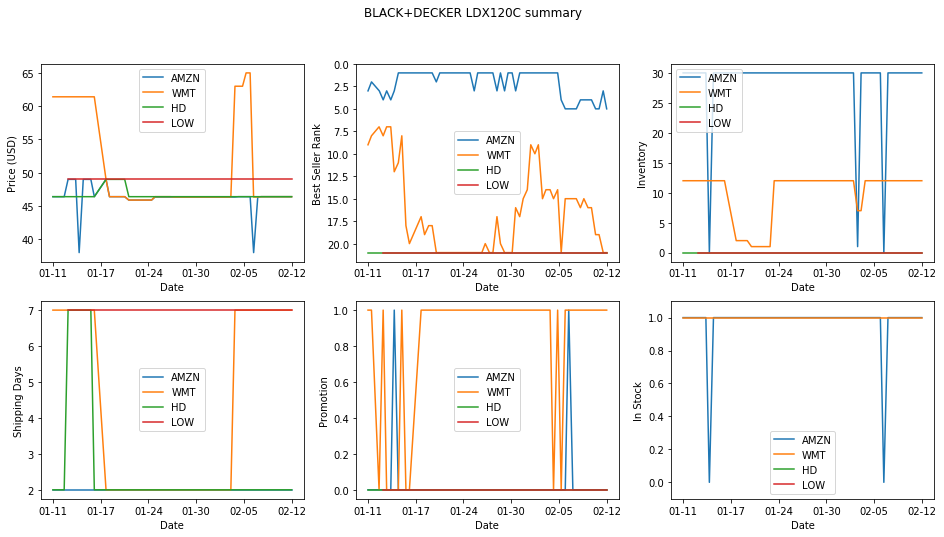

In [68]:
def create_plot(manuf,model,prices):
    platforms  = ['AMZN','WMT','HD','LOW']
    prices['new_rank'] = calc_rank(prices)
    prices['inventory'] = calc_inven(prices)
    prices['promos'] = calc_promo(prices)
    prices['shipping_days'] = calc_ship(prices)
    prod1 = prices[ (prices['manufacturer'] ==manuf) & (prices['model']==model) ]

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
    axes[0,1].set_ylim(22,0)
    axes[1,2].set_ylim(-.1,1.1)
    

    for plat in platforms:
        prod1_plat = prod1[prod1['platform']==plat]
        prod1_plat = prod1_plat.sort_values('date')
        
        axes[0,0].plot(prod1_plat['date'],prod1_plat['price'],label=plat)
        axes[0,1].plot(prod1_plat['date'],prod1_plat['new_rank'],label=plat)
        axes[0,2].plot(prod1_plat['date'],prod1_plat['inventory'],label=plat)
        
        axes[1,0].plot(prod1_plat['date'],prod1_plat['shipping_days'],label=plat)
        axes[1,1].plot(prod1_plat['date'],prod1_plat['promos'],label=plat)
        axes[1,2].plot(prod1_plat['date'],prod1_plat['in_stock'],label=plat)
        
    fig.suptitle("%s %s summary"%(manuf,model) )
    
    labels = [['Price (USD)','Best Seller Rank','Inventory'],['Shipping Days','Promotion', 'In Stock']]
    for row in range(2):
        for col in range(3):
            
            xticks =  np.linspace(prices['date'].min(),prices['date'].max(),6)
            xticks = pd.Series(xticks)
            xticklabels =  (xticks/1.0e3).apply(datetime.datetime.fromtimestamp).apply(lambda x: str(x)[5:10] )
            axes[row,col].set_xticks(xticks)
            axes[row,col].set_xticklabels(xticklabels)
            
            axes[row,col].set_xlabel('Date')
            axes[row,col].set_ylabel(labels[row][col] )
            axes[row,col].legend()   

    plt.show()


create_plot('BLACK+DECKER','LDX120C',prices)

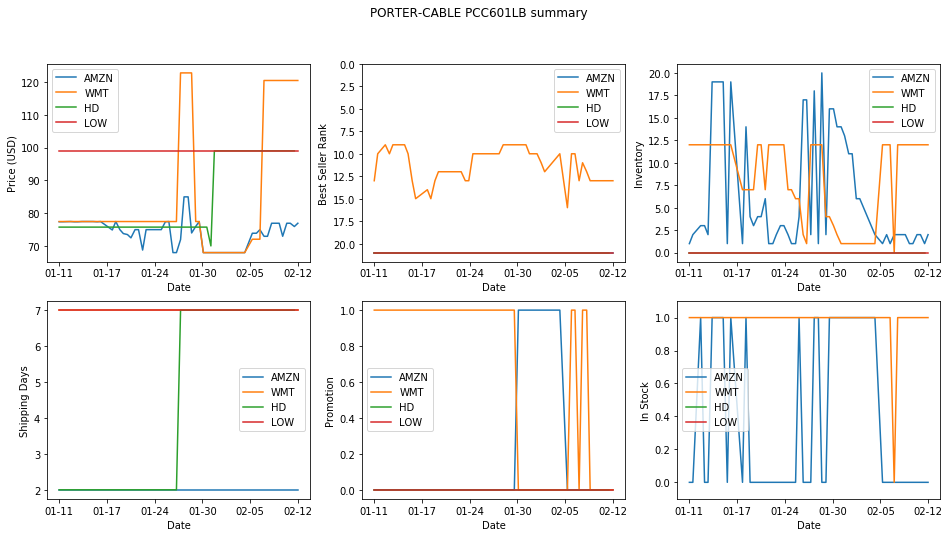

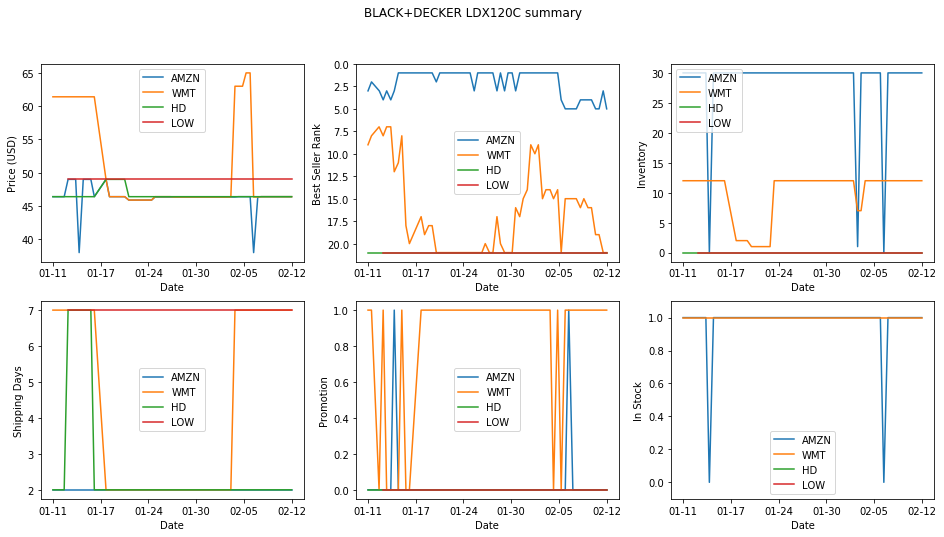

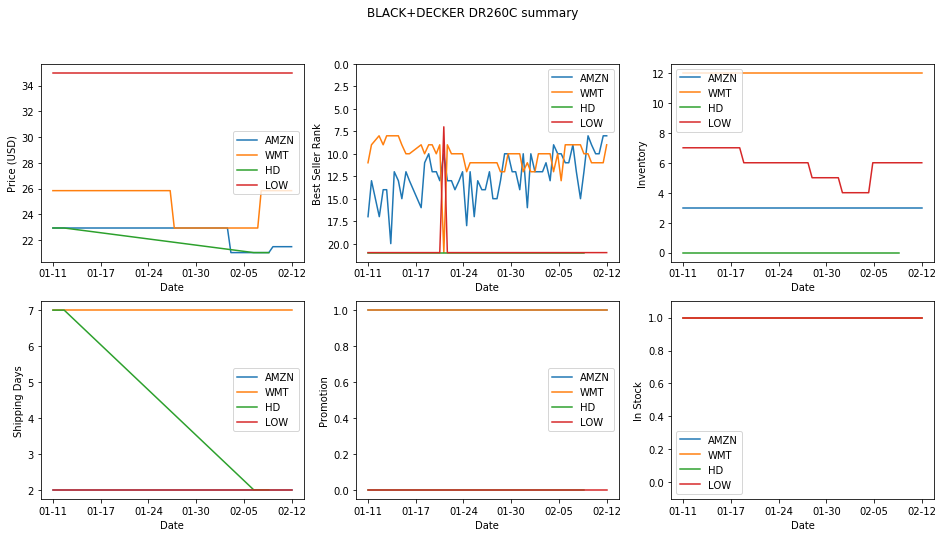

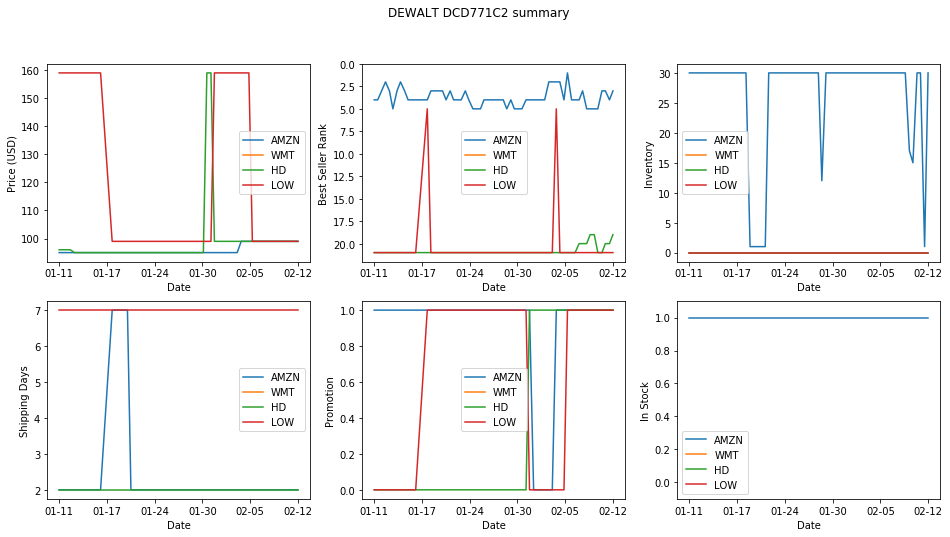

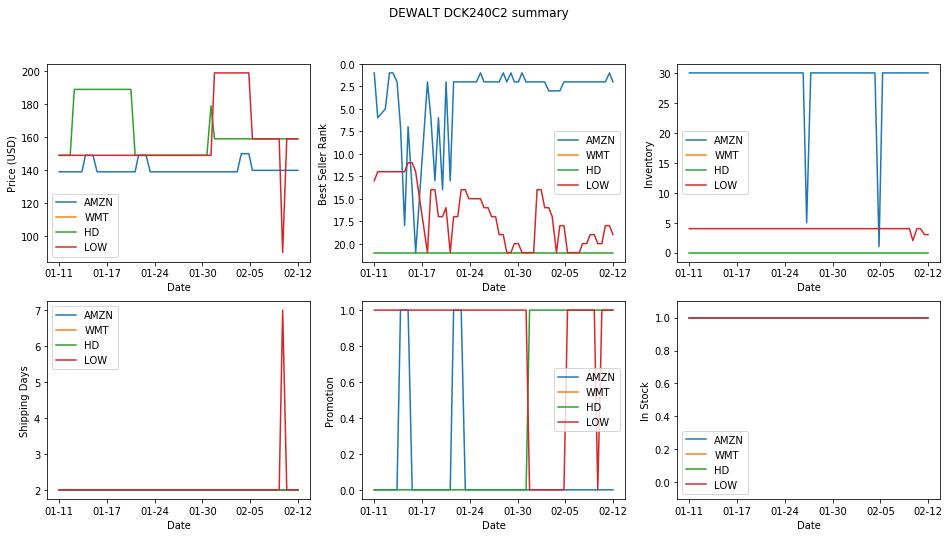

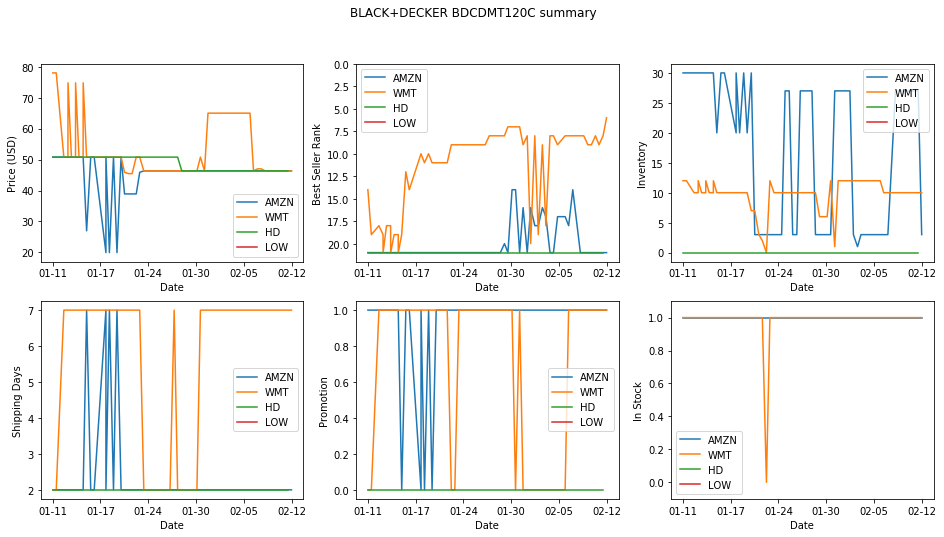

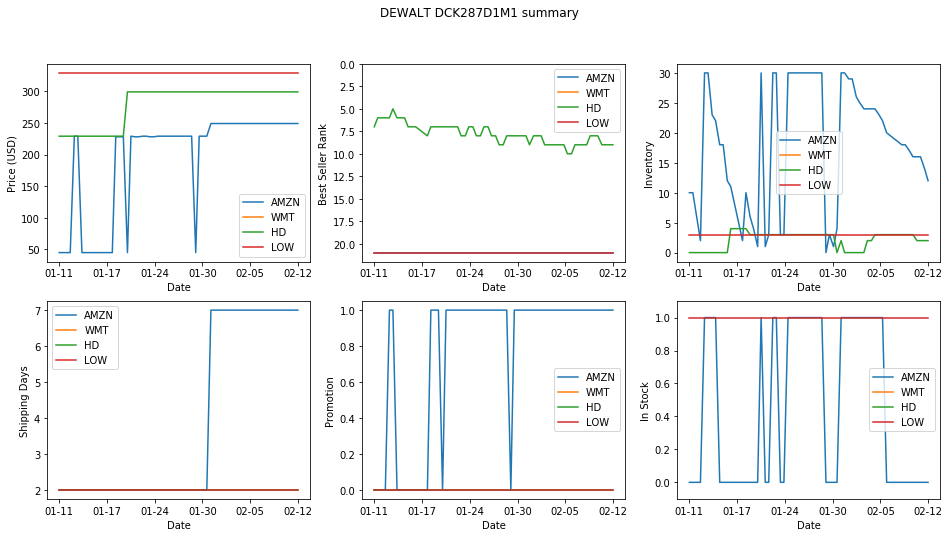

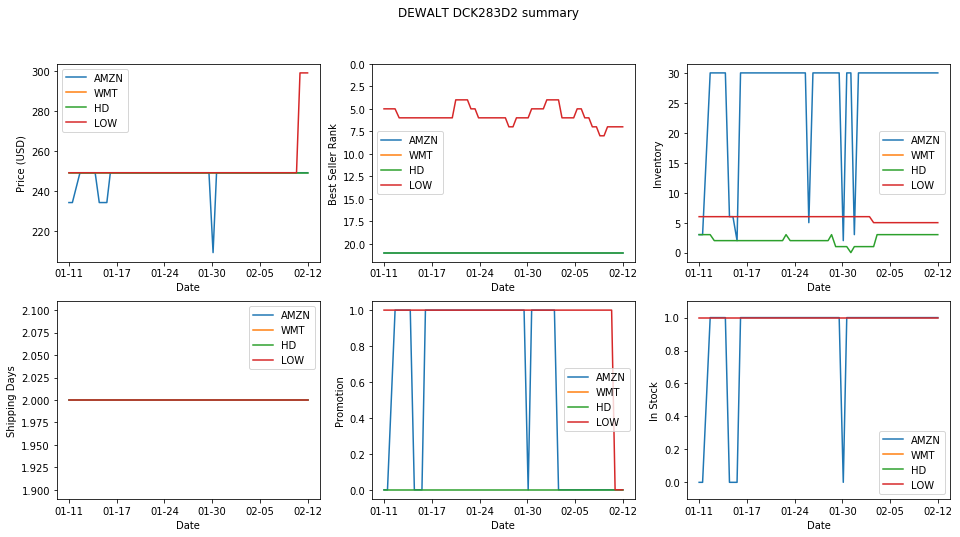

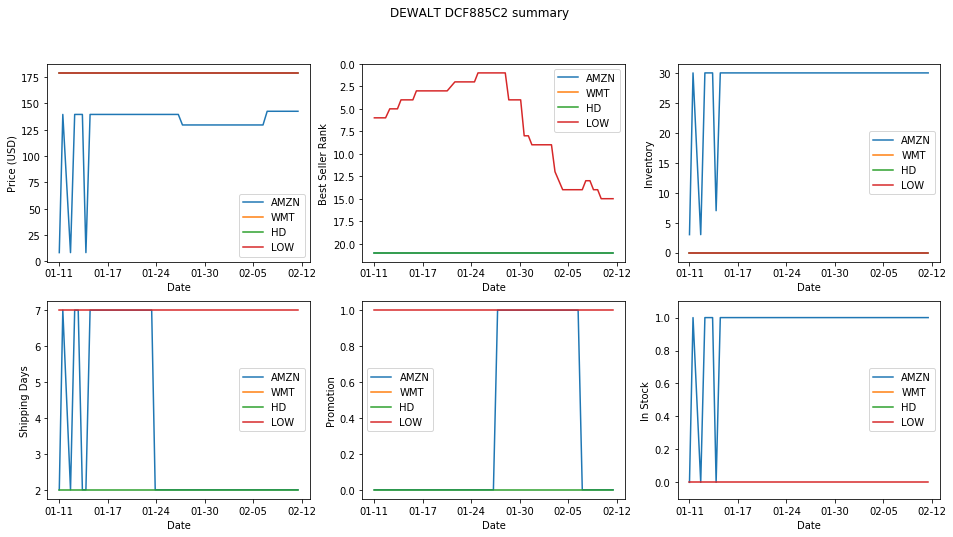

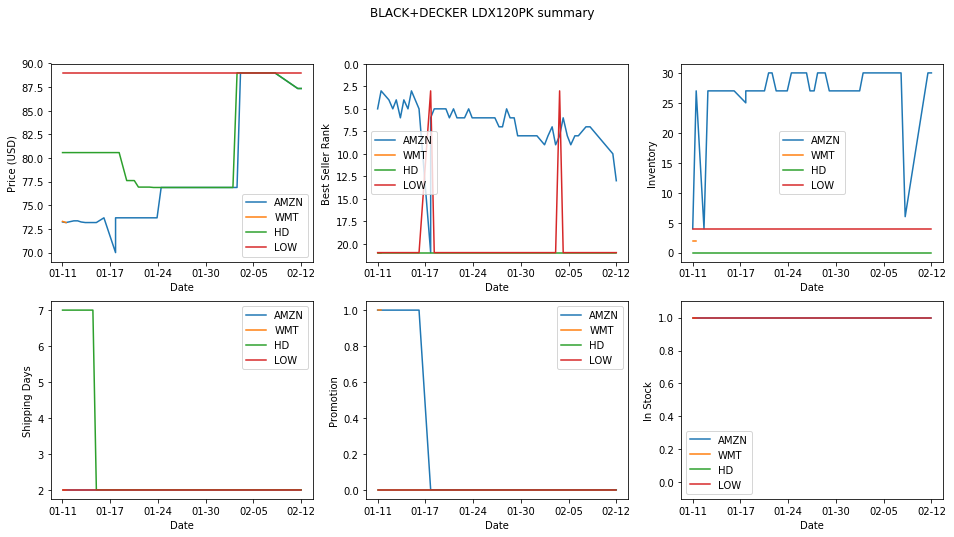

In [69]:
top_items = prices[['manufacturer','model']].groupby(['manufacturer','model']).size().reset_index()
top_items = top_items.nlargest(10, columns = 0)
for index, row in top_items.iterrows():
    create_plot(row['manufacturer'],row['model'],prices)